## STEP 1. 작업환경 구성하기


In [ ]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [26]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [27]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [28]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.

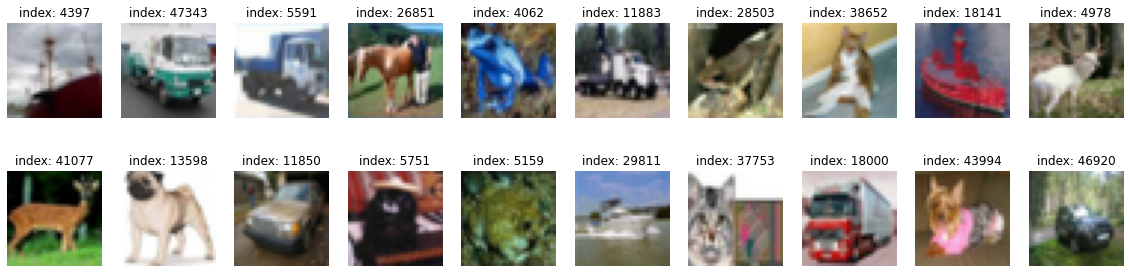

In [29]:
plt.figure(figsize=(20, 5))

for i in range(20):
    plt.subplot(2, 10, i+1)
    random_index = np.random.randint(1, 50000)
    img = train_x[random_index] / 2 + 0.5
    plt.imshow((img).reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

- 로드한 학습 데이터를 시각화를 통해 확인할 수 있습니다.

In [30]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성하였습니다.

## STEP 3. 생성자 모델 구현하기

In [2]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [31]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)        

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성하였습니다.

In [32]:
noise = tf.random.normal([1, 100])

- 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성합니다.

(1, 32, 32, 3)


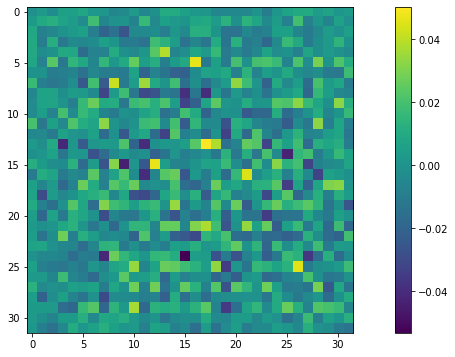

In [33]:
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는 모습을 확인할 수 있습니다.

## STEP 4. 판별자 모델 구현하기

In [34]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [35]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수입니다.

In [36]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00345793]], dtype=float32)>

- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별하게 된다면 판별자의 결과값을 얻을 수 있습니다.

## STEP 5. 손실함수와 최적화 함수 구현하기

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- `BinaryCrossentropy`를 손실함수로 사용하였습니다.

In [7]:
#생성자의 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [8]:
#판별자의 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- `discriminator_accuracy()`함수를 통해 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산해줍니다.

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

## STEP 6. 훈련과정 상세 기능 구현하기

In [38]:
noise_dim = 100
num_examples_to_generate = 16 # 100차원의 노이즈를 총 16개 생성

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

- 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인해야 합니다.
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.

In [10]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.

In [11]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) #(-1,1)로 정규화를 다시 (0,255)로
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

- `generate_and_save_images()`함수를 통해 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화합니다.

In [12]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

- `draw_train_history()`함수를 통해 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화해줍니다.

In [39]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

## STEP 7. 학습 과정 진행하기

In [13]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [40]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성됩니다.


![](https://8888-wv6wwwhbn4f0usw9pwkilf2nc.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10/training_history/train_history_0050.png)

In [43]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2079688 Feb 14 06:12 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


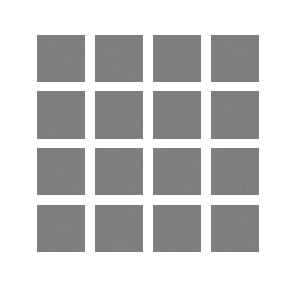
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각화하여 확인할 수 있습니다.

## STEP 8. (optional) GAN 훈련 과정 개선하기

### STEP 6을 진행하면서  훈련 과정의 문제점
- cifar10의 종류가 10가지로 많아 생성된 이미지의 원본 객체가 무엇인지 알 수 없습니다.
- 모델 구조가 단순하여 성능이 제대로 나오지 않습니다.
- 학습률이 낮아 학습속도가 더딥니다.

### 모델구조 또는 학습 과정을 개선
- cifar10 중 말의 데이터만 label을 통해 가져와 학습시킵니다.
- 모델 구조는 [여기](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)를 참고하여 수정하였습니다.
- 학습률을 1e-4에서 2e-3으로 증가시켰습니다.
- adam에 `beta_1`로 모멘텀을 0.5 주었습니다.
- ephoch를 50에서 200으로 늘려주었습니다.

In [14]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [15]:
train_x, test_x = load_data(7) #horse index : 7
train_x = (train_x - 127.5) / 127.5

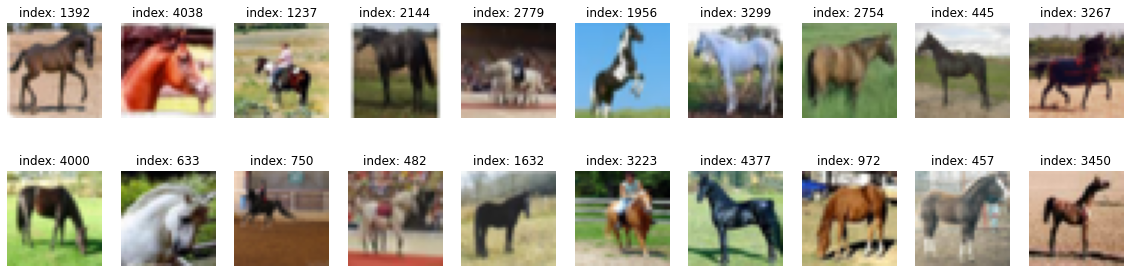

In [16]:
plt.figure(figsize=(20, 5))

for i in range(20):
    plt.subplot(2, 10, i+1)
    random_index = np.random.randint(1, 5000)
    img = train_x[random_index] / 2 + 0.5
    plt.imshow((img).reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [17]:
BUFFER_SIZE = 5000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
def define_generator(latent_dim):
    model = tf.keras.Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer
    model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
generator = define_generator(latent_dim)
# summarize the model
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

In [19]:
def define_discriminator(in_shape=(32,32,3)):
    model = tf.keras.Sequential()
    # normal
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model
 

discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) #파라메터 변경
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [21]:
noise_dim = 100
num_examples_to_generate = 16 # 100차원의 노이즈를 총 16개 생성

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [22]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints1'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

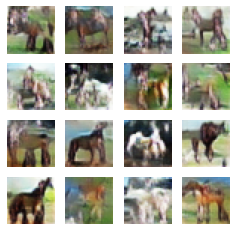

Time for training : 957 sec


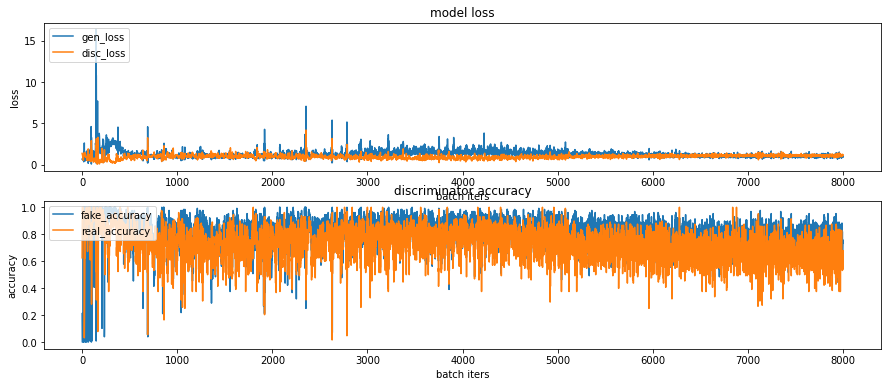

CPU times: user 16min 35s, sys: 1min 50s, total: 18min 26s
Wall time: 15min 58s


In [24]:
%%time
train(train_dataset, EPOCHS, save_every)

- accuracy가 서서히 0.5를 향해 서서히 내려오는 것을 확인할 수 있습니다.

In [25]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1014488 Feb  8 07:55 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


![cifaif](./cifar10_dcgan2.gif)
- 말 데이터셋만을 학습시킨 경우 말의 특징과 유사한 이미지가 몇 개 생성된 것을 확인할 수 있습니다.
흐릿하지만 다리가 4개있고 목이 긴 형태를 볼 수 있습니다.

# 회고
비지도 학습법 중 하나인 Generative Adversarial Network(GAN)에 대해서 공부하였습니다. 두개의 신경망 모델의 경쟁을 통해 학습하는 기존과는 다른 관점이 아주 인상깊었습니다. 실제로 말의 경우만을 학습시켰을 때 결과가 생각보다 잘 나와 놀랐습니다. 시간이 부족해 다른 label의 데이터셋을 학습시키지 못하여 아쉽습니다.